### Задание 1. Напишите код для случайных рекомендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж

### Задание 2. Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

_____

### Решение:

пройдёмся по всем рассмотренным на уроке алгоритмам, сформируем по ним рекомендации в следующих параметрах:
- **для бейзлайнов**:
  - `Random recommendation`:
    - precision@3, precision@5, recall@3, recall@5 на всех товарах
    - precision@3, precision@5, recall@3, recall@5 на ТОП-500 товарах
  - `Popularity-based recommendation`:
    - precision@3, precision@5, recall@3, recall@5
  - `Weighted random recommender`:
    - precision@3, precision@5, recall@3, recall@5
- **для детерминированных алгоритмов item-item (ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender)**:
  - `ТОП 2000`:
    - precision@3, precision@5, recall@3, recall@5
  - `ТОП 5000`:
    - precision@3, precision@5, recall@3, recall@5
  - `ТОП 10000`:
    - precision@3, precision@5, recall@3, recall@5

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix #, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import (ItemItemRecommender, CosineRecommender, 
                                         TFIDFRecommender, BM25Recommender)
import warnings
warnings.filterwarnings('ignore')

Качаем данные и смотрим на них:

In [2]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


Разобьём датасет на тренировочную и тестовую выборки, оставив в тестовой последние 3 недели:

In [3]:
data_train = data[data['week_no'] < data['week_no'].max() - 3]
data_test = data[data['week_no'] >= data['week_no'].max() - 3]

Создадим датафрейм с покупками юзеров на тестовом датасете и посмотрим на его вид:

In [4]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


создадим:
- items - товаров
- items_top_500 - ТОП-500 товаров

In [5]:
items = data_train.item_id.unique()

# Создаем список всех товаров
all_items = []
for i in result['actual']:
    all_items.extend(i)

# Считаем количество упоминаний каждого товара
item_count = {}
for item in all_items:
    if item in item_count:
        item_count[item] += 1
    else:
        item_count[item] = 1

# Сортируем товары по количеству упоминаний и оставляем только ТОП-500 товаров
top_items = sorted(item_count.items(), key=lambda x: x[1], reverse=True)[:500]
items_top_500 = np.array([item[0] for item in top_items])

print(f'{len(items)=}\n{len(items_top_500)=}')

len(items)=86865
len(items_top_500)=500


Создадим пустой датафрейм-сводную таблицу, в него будем собирать значения метрик:

In [6]:
result_table = pd.DataFrame({'name': [], 'precision@3': [], 'precision@5': [], 
                             'recall@3': [], 'recall@5': []})

А вот функции для подсчёта метрик `precision_at_k` и `recall_at_k`:

In [7]:
def precision_at_k(recommended_list, bought_list, k):
    flags = np.isin(np.array(recommended_list)[:k], np.array(bought_list))
    return flags.sum() / len(recommended_list)

def recall_at_k(recommended_list, bought_list, k):
    flags = np.isin(np.array(recommended_list)[:k], np.array(bought_list))
    return flags.sum() / len(bought_list)

теперь алгоритмы:

# Бейзлайны 

## Random recommendation

In [8]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    recs = np.random.choice(np.array(items), size=n, replace=False)
    return recs.tolist()

In [9]:
def get_random_recommendation(col_name, items, result_table=result_table):
    precision_list, recall_list = [], []
    for num in [3, 5]:
        result[col_name] =\
            result['user_id'].apply(lambda x: random_recommendation(items, n=num))
        precision_list.append(
            result.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=num), axis=1).mean())
        recall_list.append(
            result.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=num), axis=1).mean())

    result_table.loc[len(result_table)] = [col_name, precision_list[0], precision_list[1], 
                                           recall_list[0], recall_list[1]]

Получим рекомендации и посчитаем метрики для precision@3, precision@5, recall@3, recall@5 на всех товарах и ТОП-500 товарах, выведем значения метрик в таблице:

In [10]:
get_random_recommendation('random_recommendation', items=items)
get_random_recommendation('random_recommendation_top_500', items=items_top_500)
display('рекомендации:', result.iloc[:, :2].join(result.iloc[:, -2:]).head(2), 'метрики:', result_table)

'рекомендации:'

,user_id,actual,random_recommendation,random_recommendation_top_500
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1979672, 6034279, 2393949, 1069306, 2731388]","[937292, 15972074, 883932, 863447, 7442008]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1978019, 10254544, 1098549, 10356801, 17215077]","[839419, 867188, 1103629, 1060408, 968687]"


'метрики:'

,name,precision@3,precision@5,recall@3,recall@5
0,random_recommendation,0.000979,0.000881,0.000043,0.000084
1,random_recommendation_top_500,0.027261,0.022723,0.002197,0.002221


## 1.2 Popularity-based recommendation

In [11]:
def popularity_recommendation(data, n):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    recs = popular.head(n)['item_id']
    
    return recs.tolist()

In [12]:
def get_popularity_recommendation(col_name, result_table=result_table):
    precision_list, recall_list = [], []
    for num in [3, 5]:
        popular_recs = popularity_recommendation(data_train, n=num)
        result[col_name] =\
            result['user_id'].apply(lambda x: popular_recs)
        precision_list.append(
            result.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=num), axis=1).mean())
        recall_list.append(
            result.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=num), axis=1).mean())

    result_table.loc[len(result_table)] = [col_name, precision_list[0], precision_list[1], 
                                           recall_list[0], recall_list[1]]

Здесь нам не нужен ТОП-500, так как он и так формируется в popularity_recommendation:

In [13]:
get_popularity_recommendation('popularity_recommendation')
display('рекомендации:', result.iloc[:, :2].join(result.iloc[:, -1:]).head(2), 'метрики:', result_table.tail(1))

'рекомендации:'

,user_id,actual,popularity_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[6534178, 6533889, 1029743, 6534166, 1082185]"


'метрики:'

,name,precision@3,precision@5,recall@3,recall@5
2,popularity_recommendation,0.137773,0.15524,0.016013,0.024996


## Weighted random recommender

код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж

In [14]:
def weighted_random_recommendation(iw, n):
    """Случайные рекоммендации с учетом весов всех item"""    
    recs = np.random.choice(iw['item_id'], n, p=iw['item_weight'], replace=False)  
    return recs.tolist()

# найти все веса
iw = data_train.groupby('item_id')['sales_value'].sum().reset_index()
iw.columns = ['item_id', 'sales_value_sum']
iw['item_weight'] = np.log(iw['sales_value_sum'] + 1)
iw['item_weight'] = iw['item_weight'] / iw['item_weight'].sum()
iw = iw[['item_id','item_weight']]

In [15]:
def get_weighted_random_recommendation(col_name, result_table=result_table):
    precision_list, recall_list = [], []
    for num in [3, 5]:
        result[col_name] =\
            result['user_id'].apply(lambda x: weighted_random_recommendation(iw, n=num))
        precision_list.append(
            result.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=num), axis=1).mean())
        recall_list.append(
            result.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=num), axis=1).mean())

    result_table.loc[len(result_table)] = [col_name, precision_list[0], precision_list[1], 
                                           recall_list[0], recall_list[1]]

Смотрим на рекомендации и полученные метрики:

In [16]:
get_weighted_random_recommendation('weighted_random_recommendation')
display('рекомендации:', result.iloc[:, :2].join(result.iloc[:, -1:]).head(2), 'метрики:', result_table.tail(1))

'рекомендации:'

,user_id,actual,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[12428274, 6602501, 9575375, 1119112, 828143]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[9196704, 1855726, 949192, 10344716, 6442539]"


'метрики:'

,name,precision@3,precision@5,recall@3,recall@5
3,weighted_random_recommendation,0.001632,0.001763,0.00006,0.000213


# Детерминированные алгоритмы item-item

Так как у item-item-алгоритмов большая сложность, то размер выборки для рекомендаций будем ограничивать. Сформируем рекомендации и посчитаем метрики для n=3 и n=5 для ТОП-2000, ТОП-5000 и ТОП-10000:

In [17]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

Разреженные матрицы:

In [18]:
top_2000 = popularity.sort_values('n_sold', ascending=False).head(2000).item_id.tolist()
data_train_top_2000 = data_train.copy()
data_train_top_2000.loc[~data_train_top_2000['item_id'].isin(top_2000), 'item_id'] = 999999
user_item_matrix_top_2000 = pd.pivot_table(data_train_top_2000, 
                                           index='user_id', columns='item_id', 
                                           values='quantity',
                                           aggfunc='count',
                                           fill_value=0)
user_item_matrix_top_2000[user_item_matrix_top_2000 > 0] = 1              # так как в итоге хотим предсказать 
user_item_matrix_top_2000 = user_item_matrix_top_2000.astype(float)       # необходимый тип матрицы для implicit
sparse_user_item_top_2000 = csr_matrix(user_item_matrix_top_2000).tocsr() # переведем в формат saprse matrix


top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
data_train_top_5000 = data_train.copy()
data_train_top_5000.loc[~data_train_top_5000['item_id'].isin(top_5000), 'item_id'] = 999999
user_item_matrix_top_5000 = pd.pivot_table(data_train_top_5000, 
                                           index='user_id', columns='item_id', 
                                           values='quantity',
                                           aggfunc='count',
                                           fill_value=0)
user_item_matrix_top_5000[user_item_matrix_top_5000 > 0] = 1        
user_item_matrix_top_5000 = user_item_matrix_top_5000.astype(float)
sparse_user_item_top_5000 = csr_matrix(user_item_matrix_top_5000).tocsr()


top_10000 = popularity.sort_values('n_sold', ascending=False).head(10000).item_id.tolist()
data_train_top_10000 = data_train.copy()
data_train_top_10000.loc[~data_train_top_10000['item_id'].isin(top_10000), 'item_id'] = 999999
user_item_matrix_top_10000 = pd.pivot_table(data_train_top_10000, 
                                            index='user_id', columns='item_id', 
                                            values='quantity',
                                            aggfunc='count',
                                            fill_value=0)
user_item_matrix_top_10000[user_item_matrix_top_10000 > 0] = 1        
user_item_matrix_top_10000 = user_item_matrix_top_10000.astype(float)
sparse_user_item_top_10000 = csr_matrix(user_item_matrix_top_10000).tocsr()

print('разреженность матриц:\n'
      f'ТОП-2000:\n\t'
      f'{user_item_matrix_top_2000.sum().sum()/(user_item_matrix_top_2000.shape[0]*user_item_matrix_top_2000.shape[1]):.2%}'
      f'\nТОП-5000:\n\t'
      f'{user_item_matrix_top_5000.sum().sum()/(user_item_matrix_top_5000.shape[0]*user_item_matrix_top_5000.shape[1]):.2%}'
      f'\nТОП-10000:\n\t'
      f'{user_item_matrix_top_10000.sum().sum()/(user_item_matrix_top_10000.shape[0]*user_item_matrix_top_10000.shape[1]):.2%}'
     )

разреженность матриц:
ТОП-2000:
	8.61%
ТОП-5000:
	5.34%
ТОП-10000:
	3.53%


Делаем словари, в которых будут лежать реальные соответствия item_id и номера столбца. Для каждой выборки свои:

In [19]:
userids_2000 = user_item_matrix_top_2000.index.values
itemids_2000 = user_item_matrix_top_2000.columns.values

matrix_userids_2000 = np.arange(len(userids_2000))
matrix_itemids_2000 = np.arange(len(itemids_2000))

id_to_itemid_2000 = dict(zip(matrix_itemids_2000, itemids_2000))
id_to_userid_2000 = dict(zip(matrix_userids_2000, userids_2000))

itemid_to_id_2000 = dict(zip(itemids_2000, matrix_itemids_2000))
userid_to_id_2000 = dict(zip(userids_2000, matrix_userids_2000))


userids_5000 = user_item_matrix_top_5000.index.values
itemids_5000 = user_item_matrix_top_5000.columns.values

matrix_userids_5000 = np.arange(len(userids_5000))
matrix_itemids_5000 = np.arange(len(itemids_5000))

id_to_itemid_5000 = dict(zip(matrix_itemids_5000, itemids_5000))
id_to_userid_5000 = dict(zip(matrix_userids_5000, userids_5000))

itemid_to_id_5000 = dict(zip(itemids_5000, matrix_itemids_5000))
userid_to_id_5000 = dict(zip(userids_5000, matrix_userids_5000))


userids_10000 = user_item_matrix_top_10000.index.values
itemids_10000 = user_item_matrix_top_10000.columns.values

matrix_userids_10000 = np.arange(len(userids_10000))
matrix_itemids_10000 = np.arange(len(itemids_10000))

id_to_itemid_10000 = dict(zip(matrix_itemids_10000, itemids_10000))
id_to_userid_10000 = dict(zip(matrix_userids_10000, userids_10000))

itemid_to_id_10000 = dict(zip(itemids_2000, matrix_itemids_10000))
userid_to_id_10000 = dict(zip(userids_2000, matrix_userids_10000))

userids = [userids_2000, userids_5000, userids_10000]
itemids = [itemids_2000, itemids_5000, itemids_10000]
matrix_userids = [matrix_userids_2000, matrix_userids_5000, matrix_userids_10000]
matrix_itemids = [matrix_itemids_2000, matrix_itemids_5000, matrix_itemids_10000]
id_to_itemid = [id_to_itemid_2000, id_to_itemid_5000, id_to_itemid_10000]
id_to_userid = [id_to_userid_2000, id_to_userid_5000, id_to_userid_10000]
itemid_to_id = [itemid_to_id_2000, itemid_to_id_5000, itemid_to_id_10000]
userid_to_id = [userid_to_id_2000, userid_to_id_5000, userid_to_id_10000]

Теперь сами алгоритмы:

Принцип получения рекомендаций с помощью моделей `ItemItemRecommender`, `CosineRecommender`, `TFIDFRecommender` и `BM25Recommender` одинаковый, поэтому соберём код в единую функцию, которой будем передавать название модели, получать рекомендации и собирать значения метрик в нашу сводную таблицу:

In [20]:
def get_deterministic_algorithms(name_model, result_table=result_table, get_metrix=False, K=5):
    
    iter_top_list = ['_top_2000', '_top_5000', '_top_10000']
    
    for index, sparse_user_item in enumerate([sparse_user_item_top_2000, 
                                              sparse_user_item_top_5000, 
                                              sparse_user_item_top_10000]):
        precision_list, recall_list = [], []
        for num in [3, 5]:
            
            if name_model == 'ItemItemRecommender':
                model = ItemItemRecommender(K=K, num_threads=4)
            elif name_model == 'CosineRecommender':
                model = CosineRecommender(K=K, num_threads=4)
            elif name_model == 'TFIDFRecommender':
                model = CosineRecommender(K=K, num_threads=4)
            elif name_model == 'BM25Recommender':
                model = BM25Recommender(K=num, num_threads=4)
            else:
                raise AttributeError('неправильное имя модели')
                        
            model.fit(sparse_user_item)

            col_name = name_model+iter_top_list[index]

            result[col_name] = result['user_id'].\
                apply(lambda x: [id_to_itemid[index][rec] for rec in 
                                model.recommend(userid=userid_to_id[index][x], 
                                                user_items=sparse_user_item,   # на вход user-item matrix
                                                N=num, 
                                                filter_already_liked_items=False, 
                                                filter_items=[itemid_to_id[index][999999]], 
                                                recalculate_user=True)[0]])

            precision_list.append(
                result.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=num), axis=1).mean())
            recall_list.append(
                result.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=num), axis=1).mean())

        result_table.loc[len(result_table)] = [name_model+iter_top_list[index]+f', {K=}', precision_list[0], 
                                               precision_list[1], recall_list[0], recall_list[1]]
    if get_metrix:
        display('метрики:', result_table)

А теперь сформируем для каждого алгоритма рекомендации по метрикам `precision@3`, `precision@5`, `recall@3` и `recall@5`, меняя количество соседей `K=2`, `K=5` и `K=10`. Результат будем добавлять в нашу сводную таблицу, которую выведем на печать в самом конце после отработки всех алгоритмов + дополнитель отрисуем столбчатую диаграмму:

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

'метрики:'

,name,precision@3,precision@5,recall@3,recall@5
10,"ItemItemRecommender_top_2000, K=2",0.233758,0.162977,0.016859,0.019229
11,"ItemItemRecommender_top_5000, K=2",0.233758,0.162977,0.016859,0.019229
7,"ItemItemRecommender_top_2000, K=10",0.217597,0.157003,0.015042,0.017730
8,"ItemItemRecommender_top_5000, K=10",0.217597,0.157003,0.015042,0.017730
13,"CosineRecommender_top_2000, K=5",0.174012,0.135455,0.011631,0.014031
25,"TFIDFRecommender_top_2000, K=10",0.174012,0.135455,0.011631,0.014031
16,"CosineRecommender_top_2000, K=10",0.174012,0.135455,0.011631,0.014031
17,"CosineRecommender_top_5000, K=10",0.174012,0.135455,0.011631,0.014031
22,"TFIDFRecommender_top_2000, K=5",0.174012,0.135455,0.011631,0.014031
23,"TFIDFRecommender_top_5000, K=5",0.174012,0.135455,0.011631,0.014031


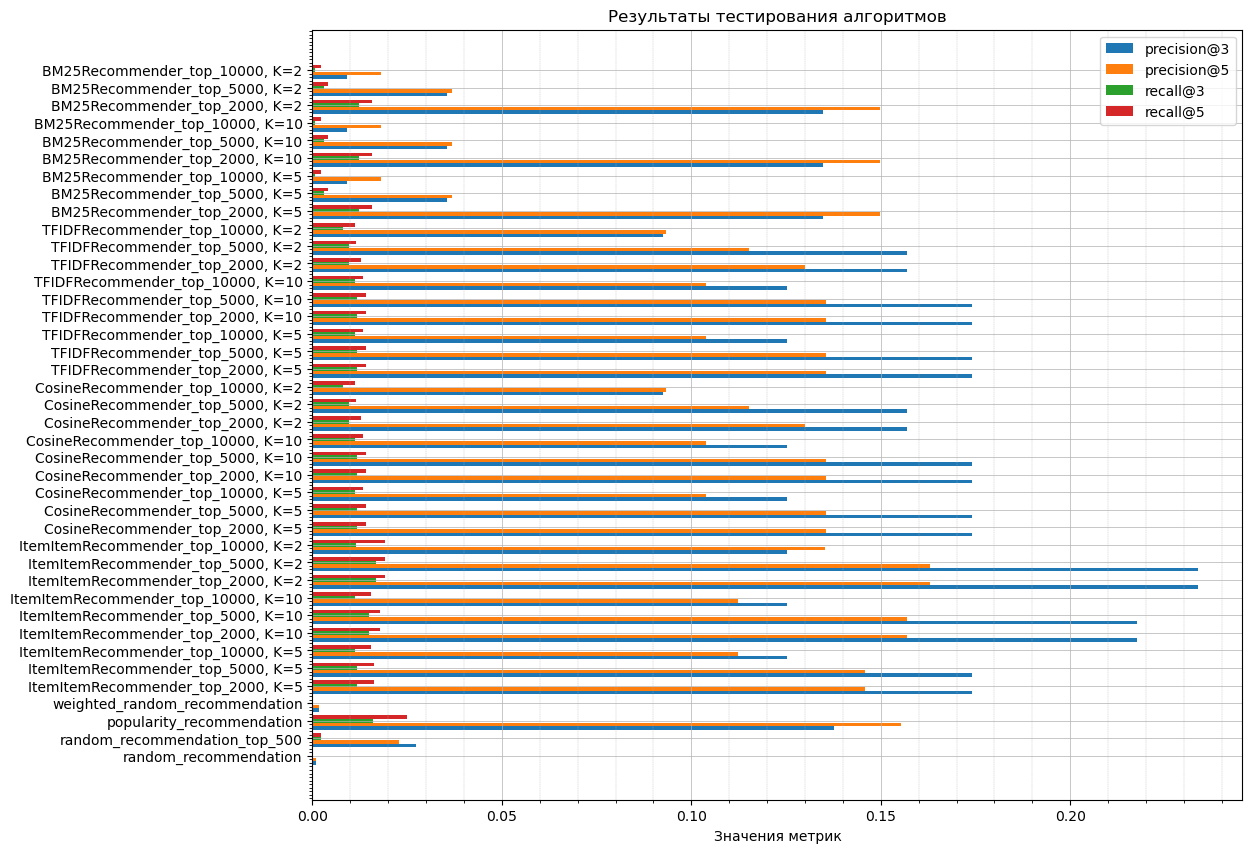

In [21]:
for alg in ['ItemItemRecommender', 'CosineRecommender', 'TFIDFRecommender', 'BM25Recommender']:
    get_deterministic_algorithms(alg)
    get_deterministic_algorithms(alg, K=10)
    get_deterministic_algorithms(alg, K=2)

display('метрики:', result_table.sort_values('precision@5', ascending=False).sort_values('precision@3', ascending=False))


names = result_table['name']
precision_3 = result_table['precision@3']
precision_5 = result_table['precision@5']
recall_3 = result_table['recall@3']
recall_5 = result_table['recall@5']
height = 0.2                                   # высота баров
fig, ax = plt.subplots(figsize=(12, 10))       # подзаголовки графика
ax.set_title('Результаты тестирования алгоритмов')
ind = np.arange(len(names))                    # массив индексов

# Отрисовка баров для каждой метрики
ax.barh(ind - 2*height, precision_3, height, label='precision@3')
ax.barh(ind - height, precision_5, height, label='precision@5')
ax.barh(ind, recall_3, height, label='recall@3')
ax.barh(ind + height, recall_5, height, label='recall@5')

ax.set_xlabel('Значения метрик')
ax.set_yticks(ind)
ax.set_yticklabels(names)
plt.legend(loc='best')

plt.minorticks_on()
plt.grid(which='major', linewidth=.5)
plt.grid(which='minor', axis='x', linewidth=.25, linestyle='--');

### Выводы:

Вот так мы сформировали аж 40 рекомендаций разными алгоритмами и посчитали 160 метрик и вот что видим:

In [22]:
result_table.shape[0], result_table.shape[0]*4

(40, 160)

`Precision` - это доля релевантных рекомендаций среди всех рекомендаций. Эта доля показывает, насколько точными являются рекомендации

`Recall` - это доля релевантных рекомендаций, которые были найдены среди всех релевантных товаров, то есть насколько полными являются рекомендации

На наших данных лучше всего показал себя `ItemItemRecommender_top_2000, K=2`-алгоритм, понижение размера выборки, количества соседей и количества самих рекомендаций действует на точность алгоритма положительно:

- precision@3 = 0.233758
- precision@5 = 0.162977
- recall@3 = 0.016859	
- recall@5 = 0.019229

`Recall` выше только у `popularity_recommendation`, он лидер среди всех бейзлайнов 

Хуже же всех результаты у `random_recommendation` и удивительного здесь мало, так как random никак не учитывает потребности пользователей и потому его рекомендации "мажут" мимо цели. 

Из интересного стоит отметить и то, что выборки top_2000 и top_5000 практически всегда дают одинаковый результат. И причина этого может заключаться в особенности данных (либо я допустил где-то косяк и не вижу его). А если нет разницы, зачем брать больше item-ов? Тем более, что top_10000 возвращает результат хуже, а значит увеличивать количество item точно не нужно.

_____